In [15]:
import numpy as np
import pandas as pd
import os
from glob import glob
from scipy.interpolate import interp1d, interp2d

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sea

from astropy.cosmology import Planck13 as cosmo
from astropy import units as u
from astropy.io import fits
from astropy.table import Table

from sim_engine import Scale_model, load_spec
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth
from spec_stats import Smooth, Highest_density_region
from spec_id import *
from spec_exam import Gen_spec

import fsps
from grizli import multifit
from grizli import model
from grizli.utils import SpectrumTemplate

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [10]:
def Gen_initial_MB(field, gid):
    # get beam list
    fl = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/BEAMS/*{}*/*{}*'.format(field,gid))
    
    # sort beams
    sz = []
    for f in fl:
        sz.append(os.path.getsize(f))

    fl = np.array(fl)[np.argsort(sz)]

    # remove repeats
    nlist = []
    blist = []
    for f in fl:
        mb = multifit.MultiBeam(f,**args)
        for bm in mb.beams:
            if bm.grism.parent_file not in nlist:
                nlist.append(bm.grism.parent_file)
                blist.append(bm)
    
    #make the mb
    mb = multifit.MultiBeam(blist,**args)

    for b in mb.beams:
        if hasattr(b, 'xp'):
            delattr(b, 'xp')
    mb.initialize_masked_arrays()
    
    return mb

def Plot_grism(MB,ax, color,instr, lims):
    sptbl = MB.oned_spectrum()

    w = sptbl[instr]['wave']
    f = sptbl[instr]['flux']
    e = sptbl[instr]['err']
    fl = sptbl[instr]['flat']
        
    clip = [U for U in range(len(w)) if lims[0] < w[U] < lims[1]]

    ax.errorbar(w[clip],f[clip]/fl[clip],e[clip]/fl[clip], color = color,
                linestyle='None', marker='o', markersize=0.25, zorder = 1, elinewidth = 1)

def Plot_beams(mb,W,P,E):
    gs = gridspec.GridSpec(2,2)

    plt.figure(figsize=[20,12])
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,1])

    for bm in mb.beams:
        xspec, yspec, yerr = bm.beam.optimal_extract(bm.grism.data['SCI'] - bm.contam,ivar = bm.ivar)

        flat_model = bm.flat_flam.reshape(bm.beam.sh_beam)
        xspecm, yspecm, yerrm = bm.beam.optimal_extract(flat_model)

        if bm.grism.filter == 'G102':
            IDX = [U for U in range(len(xspec)) if 8000 < xspec[U] < 11300]
            ax1.plot(xspec[IDX],yspec[IDX]/yspecm[IDX], color = 'b')
        else:
            IDX = [U for U in range(len(xspec)) if 11200 < xspec[U] < 16500]
            ax2.plot(xspec[IDX],yspec[IDX]/yspecm[IDX], color = 'r') 
    
    ax = plt.subplot(gs[1,:])
    try:
        Plot_grism(mb , ax, 'b', 'G102', [8000,11500])
    except:
        pass
    try:
        Plot_grism(mb , ax, 'r', 'G141', [11000,16500])
    except:
        pass
    
    IDP = [U for U in range(len(W)) if P[U]/E[U]  > 0.05]

    
    ax.errorbar(np.array(W)[IDP],np.array(P)[IDP],np.array(E)[IDP], fmt='o', color='k', zorder=0)
    ax.set_xscale('log')    
    
def Beam_cleanup(mb, B_condition=[], R_condition=[]):
    ## conditions in form of [low-wv, hi-wv, gtr or less, flux, clip or omit]
    Bselect = False
    Rselect = False
    
    if len(B_condition) == 5:
        Bwvl, Bwvh, B_cond, Bfl, B_cl = B_condition
        Bselect = True

    if len(R_condition) == 5:
        Rwvl, Rwvh, R_cond, Rfl, R_cl = R_condition
        Rselect = True

    BEAM_exempt =[]
    ids = 0
    cleanspec = []
    clip_lims = []
    ### selection for bad beams
    for bm in mb.beams:
        xspec, yspec, yerr = bm.beam.optimal_extract(bm.grism.data['SCI'] - bm.contam,ivar = bm.ivar)
        flat_model = bm.flat_flam.reshape(bm.beam.sh_beam)
        xspecm, yspecm, yerrm = bm.beam.optimal_extract(flat_model)
        bex = False

        if Bselect:
            for i in range(len(xspec)):
                if B_cond == 'gtr':
                    if (bm.grism.filter == 'G102' and Bwvl < xspec[i] < Bwvh) and (yspec[i]/yspecm[i]) > Bfl:
                        bex = True
                        cleanspec.append(B_cl)
                        clip_lims.append([Bwvl, Bwvh])
                        break

                if B_cond == 'less':
                    if (bm.grism.filter == 'G102' and Bwvl < xspec[i] < Bwvh) and (yspec[i]/yspecm[i]) < Bfl:
                        bex = True
                        cleanspec.append(B_cl)
                        clip_lims.append([Bwvl, Bwvh])
                        break
        
        if Rselect:
            for i in range(len(xspec)):
                if R_cond == 'gtr':
                    if (bm.grism.filter == 'G141' and Rwvl < xspec[i] < Rwvh) and (yspec[i]/yspecm[i]) > Rfl:
                        bex = True
                        cleanspec.append(R_cl)
                        clip_lims.append([Rwvl, Rwvh])
                        break

                if R_cond == 'less':
                    if (bm.grism.filter == 'G141' and Rwvl < xspec[i] < Rwvh) and (yspec[i]/yspecm[i]) < Rfl:
                        bex = True
                        cleanspec.append(R_cl)
                        clip_lims.append([Rwvl, Rwvh])
                        break

        if bex:
            BEAM_exempt.append(bm.grism.parent_file)

    ### set up selection settings
    
    omitspec = np.zeros(len(BEAM_exempt))
    clipspec = np.zeros(len(BEAM_exempt))
    for i in range(len(cleanspec)):
        if cleanspec[i] == 'clip':
            clipspec[i] = 1
            
        if cleanspec[i] == 'omit':
            omitspec[i] = 1   
    return BEAM_exempt, clip_lims, clipspec, omitspec
            
def Clean_mb(mb, BEAM_exempt, clip_lims, clipspec, omitspec):   
    fblist = []
    idc = 0
    for bm in mb.beams:
        if bm.grism.parent_file in BEAM_exempt:            
            if clipspec[idc] == 1:
                xspec, yspec, yerr = bm.beam.optimal_extract(bm.grism.data['SCI'] - bm.contam,ivar = bm.ivar) 
                lms = clip_lims[idc]
                for i in range(len(xspec)):
                    if lms[0] < xspec[i]< lms[1]:
                        bm.grism.data['SCI'].T[i] = np.zeros_like(bm.grism.data['SCI'].T[i])
                        bm.grism.data['ERR'].T[i] = np.ones_like(bm.grism.data['ERR'].T[i])*1000  

            if omitspec[idc] == 1:
                pass
            else:    
                fblist.append(bm)

            idc += 1

        else:    
            fblist.append(bm)   

    mb = multifit.MultiBeam(fblist,**args)
    for b in mb.beams:
        if hasattr(b, 'xp'):
            delattr(b, 'xp')
    mb.initialize_masked_arrays()
    
    return mb

def Phot_load(field, galaxy_id,ref_cat_loc,masterlist = '../phot/master_template_list.pkl'):
    galdf = ref_cat_loc[ref_cat_loc.id == galaxy_id]
    master_tmp_df = pd.read_pickle(masterlist)

    if field == 'GSD':
        pre= 'S_'

    if field == 'GND':
        pre= 'N_'

    eff_wv = []
    phot_fl = []
    phot_er = []
    phot_num = []

    for i in galdf.keys():
        if i[0:2] == 'f_':
            Clam = 3E18 / master_tmp_df.eff_wv[master_tmp_df.tmp_name == pre + i].values[0] **2 * 10**((-1.1)/2.5-29)
            if galdf[i].values[0] > -99.0:
                eff_wv.append(master_tmp_df.eff_wv[master_tmp_df.tmp_name == pre + i].values[0])
                phot_fl.append(galdf[i].values[0]*Clam)
                phot_num.append(master_tmp_df.tmp_num[master_tmp_df.tmp_name == pre + i].values[0])
        if i[0:2] == 'e_':
            if galdf[i].values[0] > -99.0:
                phot_er.append(galdf[i].values[0]*Clam)
    
    return eff_wv, phot_fl, phot_er

In [11]:
# GND_all = pd.read_pickle('../dataframes/galaxy_frames/GND_CLEAR.pkl')
# GSD_all = pd.read_pickle('../dataframes/galaxy_frames/GSD_CLEAR.pkl')

# GND_all = pd.read_pickle('../dataframes/galaxy_frames/massMetal_GND_full.pkl')
# GSD_all = pd.read_pickle('../dataframes/galaxy_frames/massMetal_GSD_full.pkl')


v4N = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()
v4S = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()

v4Ncat = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Catalog/goodsn_3dhst.v4.4.cat',
                 format='ascii').to_pandas()
v4Scat = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Catalog/goodss_3dhst.v4.4.cat',
                 format='ascii').to_pandas()

v4N['use'] = v4Ncat['use_phot']
v4S['use'] = v4Scat['use_phot']

v4N['star'] = v4Ncat['class_star']
v4S['star'] = v4Scat['class_star']

v4N['f125'] = v4Ncat['f_F125W']
v4S['f125'] = v4Scat['f_F125W']

v4N['f160'] = v4Ncat['f_F160W']
v4S['f160'] = v4Scat['f_F160W']

# filesN = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/BEAMS/*N*/*.beams.fits')
# filesS = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/BEAMS/*S*/*.beams.fits')

# allNids = [int(os.path.basename(U).replace('.beams.fits','').split('_')[1]) for U in filesN]
# allSids = [int(os.path.basename(U).replace('.beams.fits','').split('_')[1]) for U in filesS]

# Nids = np.array(list(set(allNids)))
# Sids = np.array(list(set(allSids)))

# Npresent = [U in Nids for U in v4N.id]
# Spresent = [U in Sids for U in v4S.id]

# v4N['grism'] = Npresent
# v4S['grism'] = Spresent

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits'

In [4]:
temps = {}
for k in args['t1']:
    if k[0] == 'f' or k[5:] in ['Ha', 'Hb', 'Hg', 'Hd'] :
        temps[k] = args['t1'][k]

In [5]:
NGSID = np.load('../dataframes/N_GSD.npy', allow_pickle=True)
NGNID = np.load('../dataframes/N_GND.npy', allow_pickle=True)

NGSz = np.load('../dataframes/N_GSD_z.npy', allow_pickle=True)
NGNz = np.load('../dataframes/N_GND_z.npy', allow_pickle=True)

gsd_spec = np.load(data_path + 'GSD_new.npy', allow_pickle = True).item()
gnd_spec = np.load(data_path + 'GND_new.npy', allow_pickle = True).item()

SID_pass = []
Sz_pass = []
NID_pass = []
Nz_pass = []

for i in range(len(NGSID)):
    try:
        Bwv = gsd_spec['{}'.format(NGSID[i])]['g102_wv']
        SID_pass.append(NGSID[i])
        Sz_pass.append(NGSz[i])
        
    except:
        pass

    
for i in range(len(NGNID)):
    try:
        Bwv = gnd_spec['{}'.format(NGNID[i])]['g102_wv']
        NID_pass.append(NGNID[i])
        Nz_pass.append(NGNz[i])
        
    except:
        pass
    
omit_GSD=[24857,25940,36659,37197,38645,39232,40046,41319,41470,42105,44767,44805,44816,44857,45922,46576,\
35937,37885,38119,38880,39449,39671,40440,40745,43390,49063]

omit_GND=[ 11115,14098,14140,14533,16987,19554,19725,20052,21481, 35526,36512, 37406,37469,\
12300,12568,14039,16454,18145,19955,20356,20924,21298,22535,23682,26937,33395,34753,35725,37321]

In [341]:
from shutil import copy
for i in range(len(SID_pass)):
    if not SID_pass[i] in omit_GSD:
#         try:
        copy('../plots/newspec_check/GSD_{}.png'.format(SID_pass[i]), '../plots/newspec_check_2/GSD_{}.png'.format(SID_pass[i]))
#         except:
#             pass
        
for i in range(len(NID_pass)):
    if not NID_pass[i] in omit_GND:
        try:
            copy('../plots/newspec_check/GND_{}.png'.format(NID_pass[i]), '../plots/newspec_check_2/GND_{}.png'.format(NID_pass[i]))
        except:
            pass

In [334]:
for i in range(len(omit_GND)):
    if not omit_GND[i] in NGNID:
        print(omit_GND[i])

In [332]:
omit_GSD=[24857,25940,36659,37197,38645,39232,40046,41319,41470,42105,44767,44805,44816,44857,45922,46576,\
35937,37885,38119,38880,39449,39671,40440,40745,43390,49063]

omit_GND=[ 11115,14098,14140,14533,16987,19554,19725,20052,21481, 35526,36512, 37406,37469,\
12300,12568,14039,16454,18145,19955,20356,20924,21298,22535,23682,26937,33395,34753,35725,37321]

In [327]:
# db = GSD_all
field = 'S'
# cat = GSD_all
gid =49269

# idx = db.query('id ==45329').index[0]
# rshift = db.zphot[idx] 
# rshift = cat.query('id == {}'.format(gid)).z_50.values[0] 
rshift = NGSz[np.argwhere(NGSID == gid)[0]][0]

# if len(str(db.id[idx])) < 5:
#     gid = '0' + str(db.id[idx])
# else:
#     gid = str(db.id[idx])

# W,P,E = Phot_load('G{}D'.format(field), db.id[idx], cat)
# W,P,E = Phot_load('G{}D'.format(field), gid, cat)

W, wr, P, E, N = load_spec('G{}D'.format(field),gid, 'phot',[],  rshift, grism = False, select = None)

mb  = Gen_initial_MB(field, gid)

load_master_fits: /Volumes/Vince_CLEAR/RELEASE_v2.1.0/BEAMS/GS2/GS2_49269.beams.fits
1 ibhj03xoq_flt.fits G141
2 ibhj03xvq_flt.fits G141
3 ibhj03y2q_flt.fits G141
4 ibhj03y9q_flt.fits G141
5 icxt03jjq_flt.fits G102
6 icxt03jkq_flt.fits G102
7 icxt03jnq_flt.fits G102
8 icxt03jpq_flt.fits G102
9 icxt04e3q_flt.fits G102
10 icxt04e4q_flt.fits G102
11 icxt04edq_flt.fits G102
12 icxt04efq_flt.fits G102
13 icxt01cgq_flt.fits G102
14 icxt01ciq_flt.fits G102
15 icxt01clq_flt.fits G102
16 icxt01cnq_flt.fits G102
17 icxt02c7q_flt.fits G102
18 icxt02caq_flt.fits G102
19 icxt02cdq_flt.fits G102
20 icxt02cfq_flt.fits G102
21 icxt05h7q_flt.fits G102
22 icxt05h9q_flt.fits G102
23 icxt05hcq_flt.fits G102
24 icxt05heq_flt.fits G102
25 icxt06laq_flt.fits G102
26 icxt06lcq_flt.fits G102
27 icxt06lfq_flt.fits G102
28 icxt06lhq_flt.fits G102


/Users/Vince.ec/miniconda3/envs/astroconda3.6/lib/python3.6/site-packages/grizli-1.2.dev1648-py3.6-macosx-10.9-x86_64.egg/grizli/multifit.py:1647: RuntimeWarning: divide by zero encountered in true_divide
  ivar = 1./(1/b.ivar + (self.sys_err*sciu)**2)
/Users/Vince.ec/miniconda3/envs/astroconda3.6/lib/python3.6/site-packages/grizli-1.2.dev1648-py3.6-macosx-10.9-x86_64.egg/grizli/model.py:590: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


[]
[] []
[]


/Users/Vince.ec/miniconda3/envs/astroconda3.6/lib/python3.6/site-packages/grizli-1.2.dev1648-py3.6-macosx-10.9-x86_64.egg/grizli/multifit.py:1647: RuntimeWarning: divide by zero encountered in true_divide
  ivar = 1./(1/b.ivar + (self.sys_err*sciu)**2)
/Users/Vince.ec/miniconda3/envs/astroconda3.6/lib/python3.6/site-packages/grizli-1.2.dev1648-py3.6-macosx-10.9-x86_64.egg/grizli/model.py:590: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


S 49269 0.9715457308299433


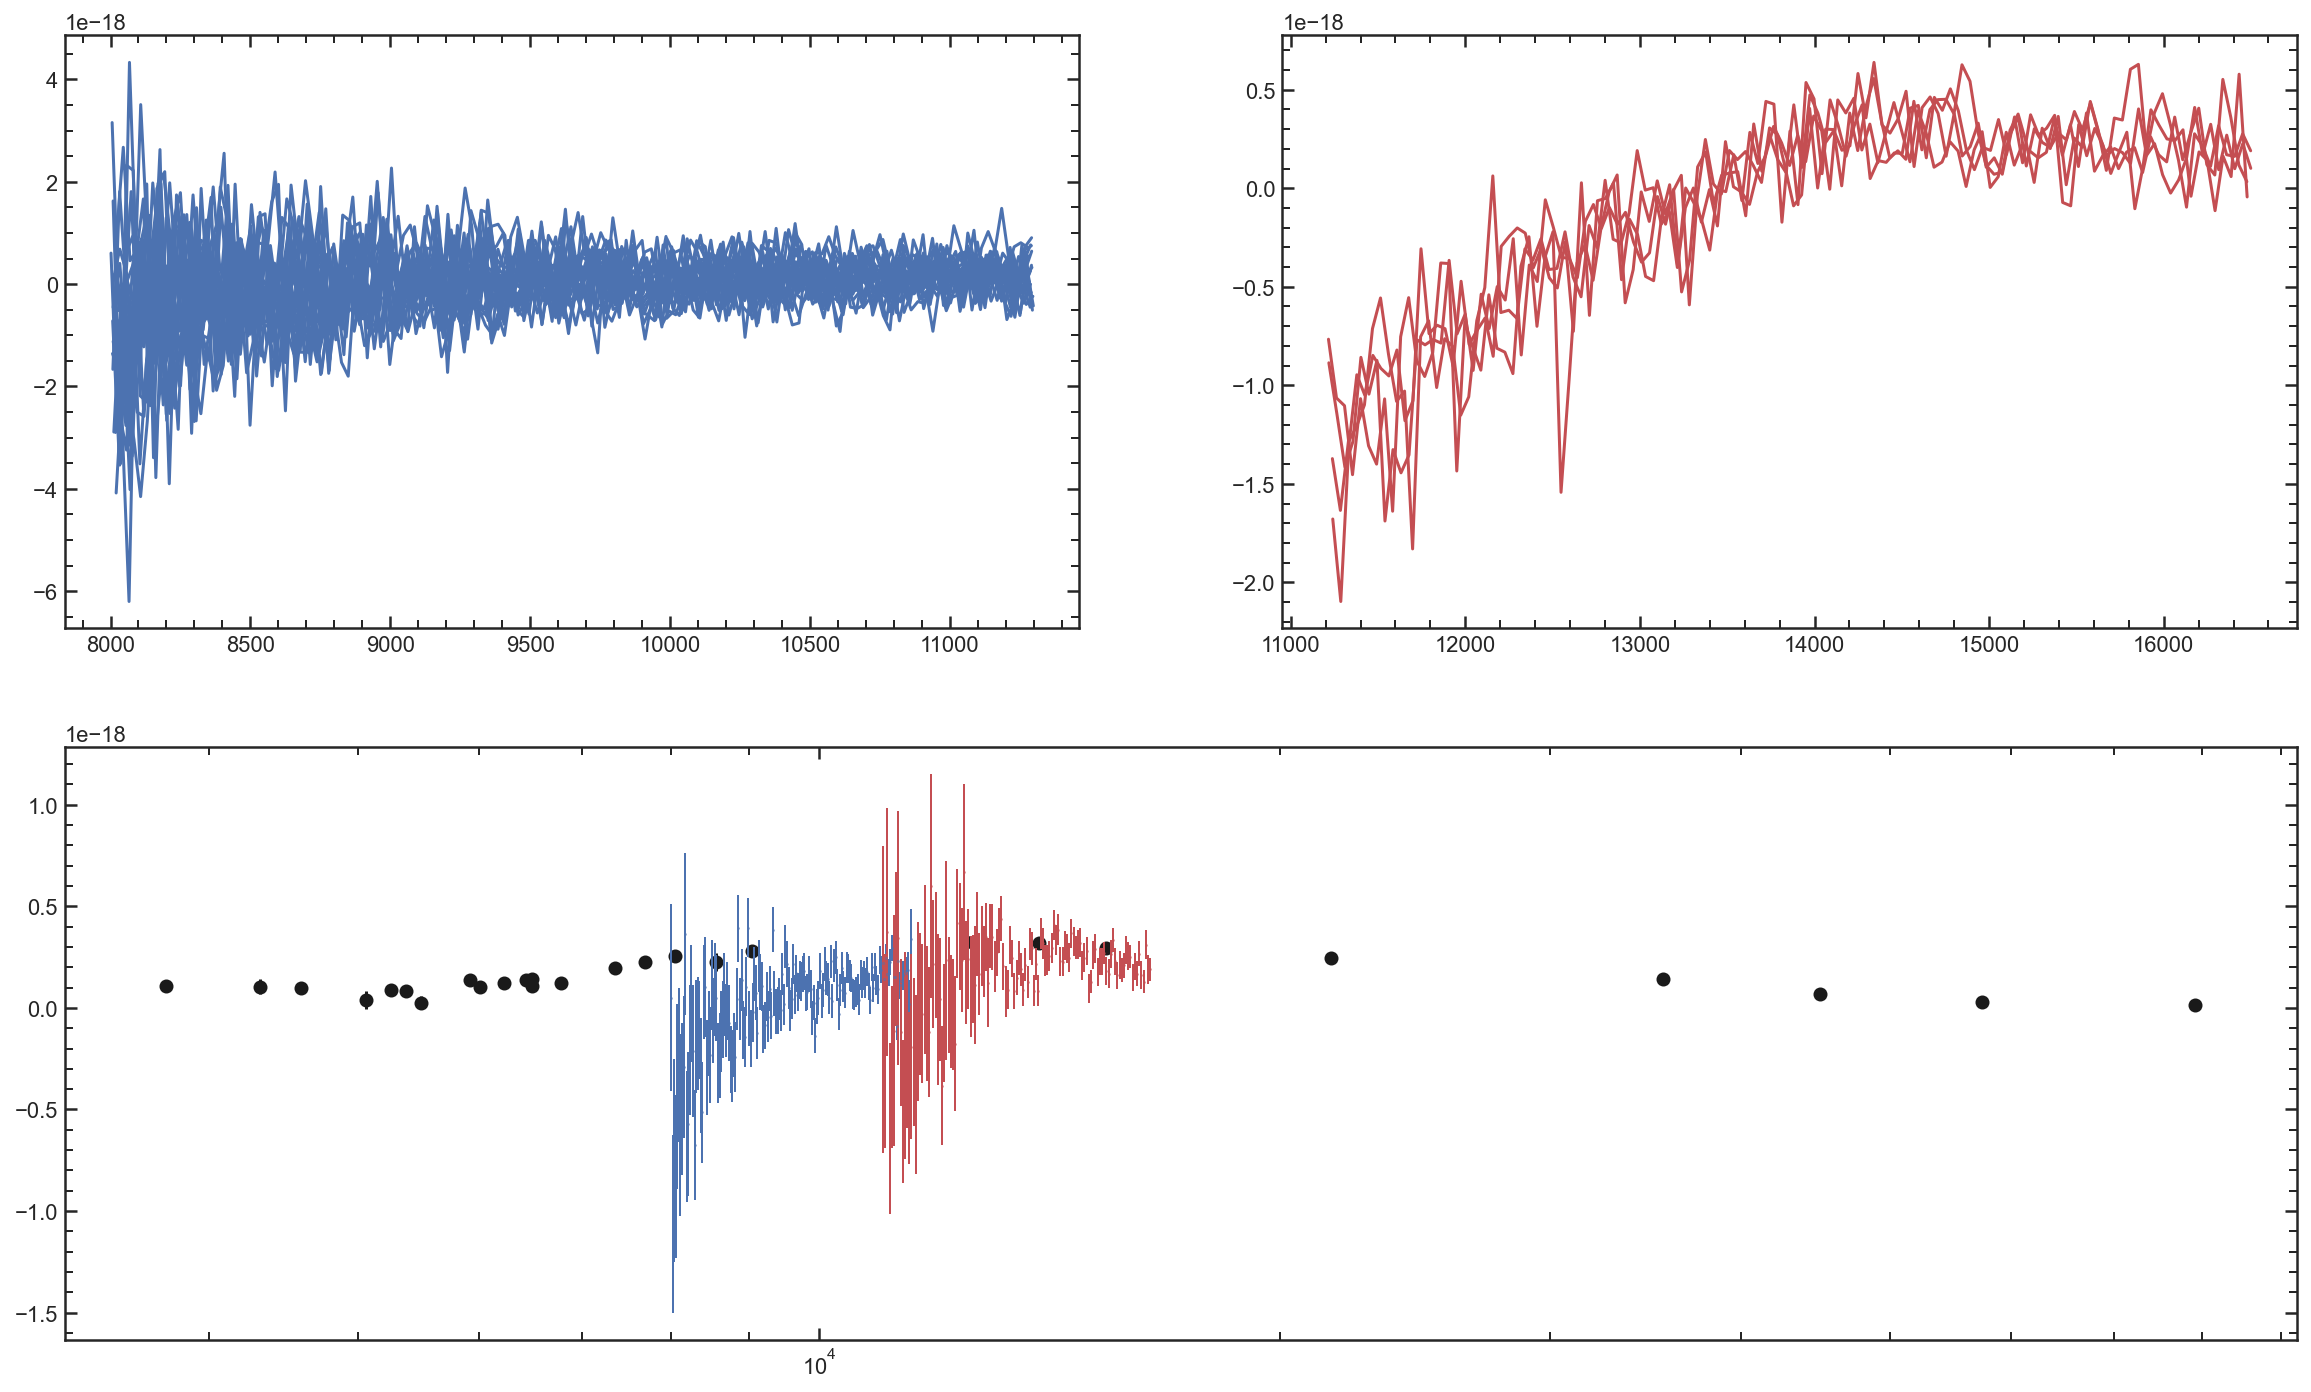

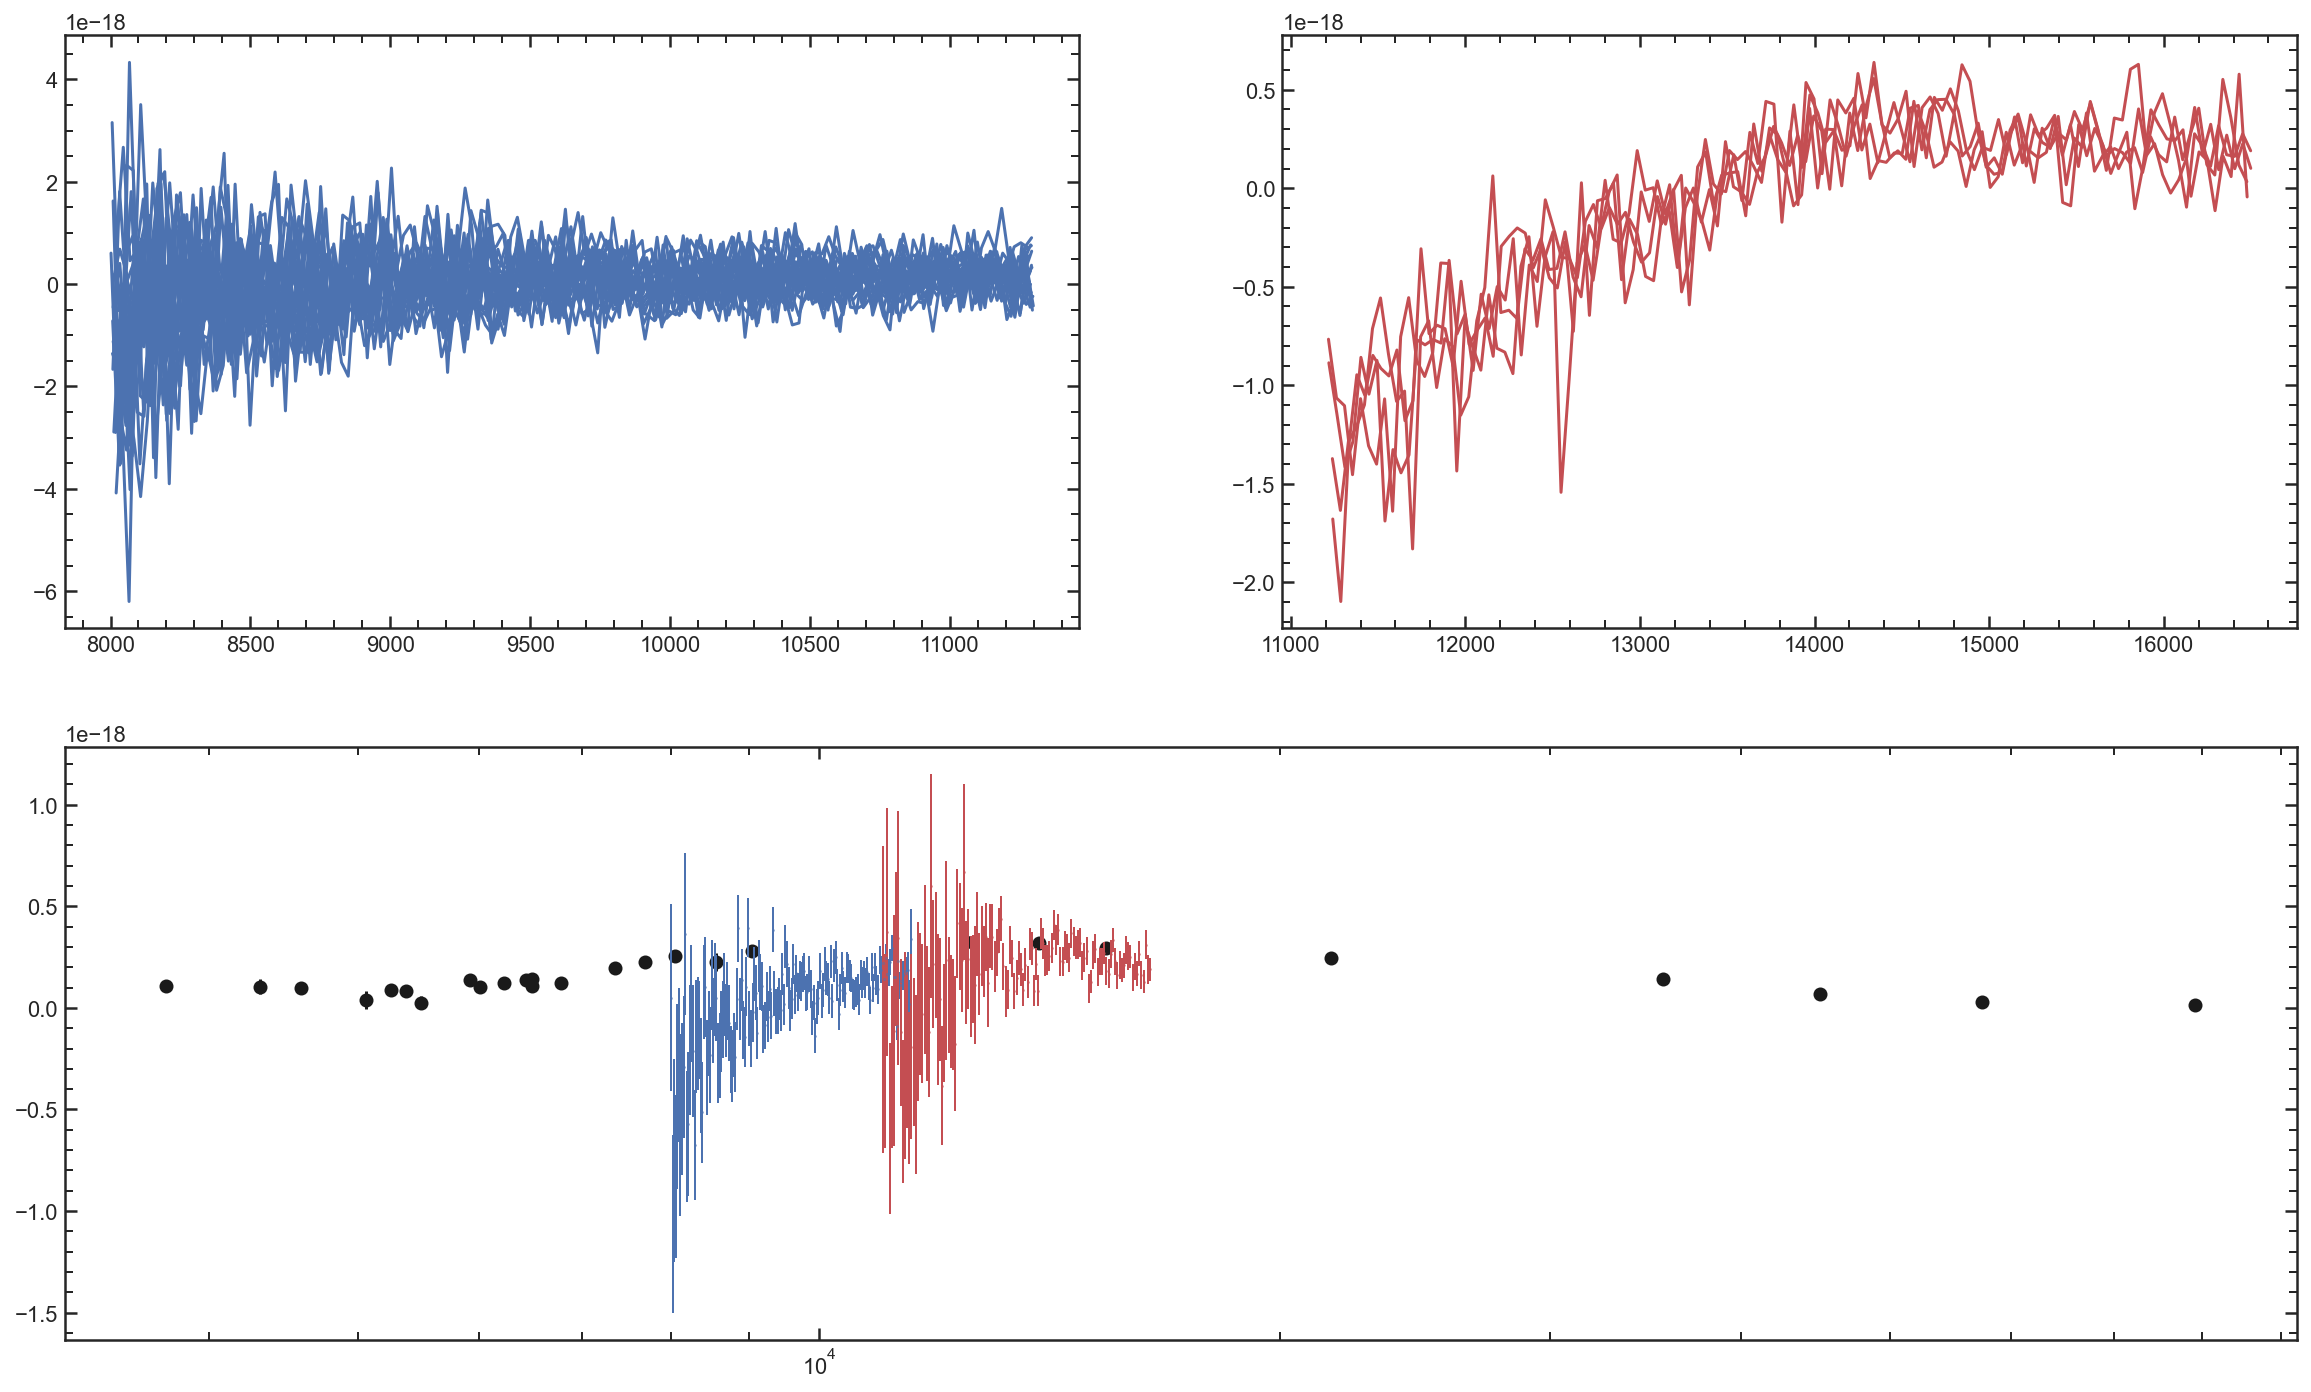

In [328]:
## conditions in form of [low-wv, hi-wv, gtr or less, flux, clip or omit]
#12500, 13500, 'gtr', 0, 'clip'
Plot_beams(mb,W,P,E)
BMX, Clims, Cspec, Ospec = Beam_cleanup(mb, B_condition=[], R_condition=[])
print(BMX)
print(Clims, Cspec)
print(Ospec)

MB = Clean_mb(mb, BMX, np.array(Clims), Cspec, Ospec)
Plot_beams(MB,W,P,E)

np.save('../beams/beam_config/G{}D_{}_ex'.format(field, gid),[BMX])
np.save('../beams/beam_config/G{}D_{}'.format(field, gid),[Clims, Cspec, Ospec])

print(field, gid, rshift)

In [22]:
2.8*4000

11200.0

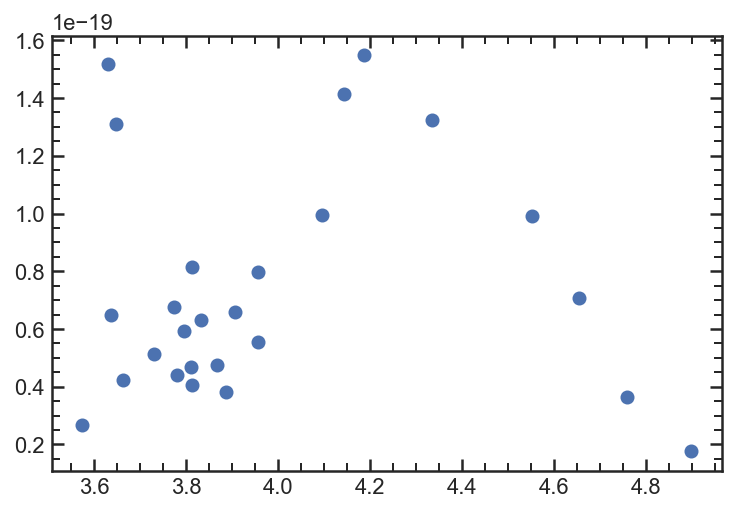

In [50]:
plt.scatter(np.log10(W),P)

In [83]:
import george
from george import kernels

In [84]:
kernels.LinearKernel(5)

ValueError: missing required parameter 'order'

In [85]:
george.__version__

'0.3.1'